### Aca voy a revolear todos los calculos que se utilizan para los sensores y estan en defines.h

#### Sensor de Temperatura NTC:

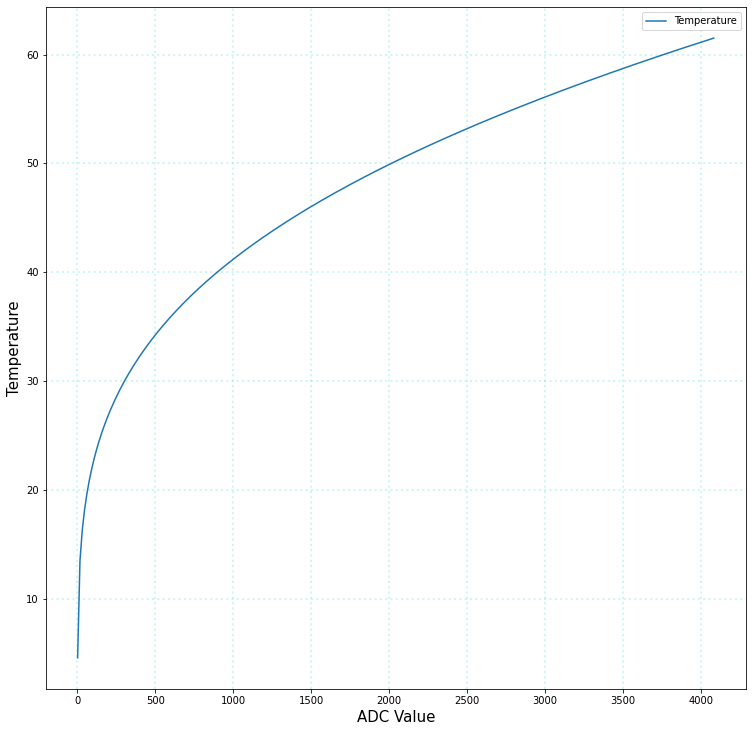

In [34]:
import numpy as np
import math
import matplotlib.pyplot as plt

from openefi_common import convert_to_resistance, sample_adc_values

#Constantes del sensor NTC:

A = 1.12492089e-3
B = 2.372075385e-4
C = 6.954079529e-8

ADC_Values = sample_adc_values()
Temp = []

for ADC_Value in sample_adc_values():
    if ADC_Value != 0:
        R = convert_to_resistance(ADC_Value);
        logR = math.log(R);
        kelvin = 1 / (A + B * logR + C * logR * logR * logR)
        Temp.append((kelvin - 273.15)/10)

# vamo' a plotear

plt.plot(ADC_Values, Temp, label='Temperature')
plt.xlabel('ADC Value', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
plt.rcParams['figure.figsize'] = [8, 8]
plt.legend()
plt.show()
